<a href="https://colab.research.google.com/github/ryancburke/Sign-language-image-recognition/blob/master/sign_language_recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## load packages

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

Using TensorFlow backend.


##upload data sets

In [0]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [0]:
# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1UyF-6Rco-1bpofb-n3yPADpZb5aGempm'
downloaded = drive.CreateFile({'id': file_id})
train = pd.read_csv('/gdrive/My Drive/sign_mnist_train.csv')

In [0]:
file_id = '1M27ccHcfHRqO8HPUki4hhzsvLpSZ2o_O'
downloaded = drive.CreateFile({'id': file_id})
test = pd.read_csv('/gdrive/My Drive/sign_mnist_test.csv')

##load data

17    1294
16    1279
11    1241
22    1225
5     1204
18    1199
14    1196
3     1196
19    1186
23    1164
8     1162
20    1161
13    1151
2     1144
0     1126
24    1118
10    1114
6     1090
15    1088
21    1082
12    1055
7     1013
1     1010
4      957
Name: label, dtype: int64

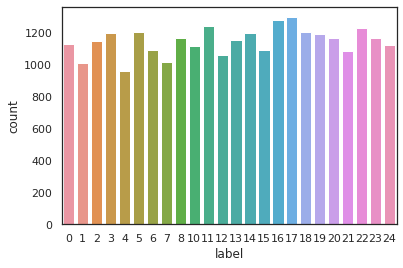

In [0]:
Y_train = train["label"]
Y_test = test["label"]

# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1) 
X_test = test.drop(labels = ["label"],axis = 1 )

# Free some space
del train
del test

g = sns.countplot(Y_train)

Y_train.value_counts()

## check for missing values

In [0]:
# Check the data
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [0]:
X_train.describe

<bound method NDFrame.describe of        pixel1  pixel2  pixel3  pixel4  ...  pixel781  pixel782  pixel783  pixel784
0         107     118     127     134  ...       206       204       203       202
1         155     157     156     156  ...       175       103       135       149
2         187     188     188     187  ...       198       195       194       195
3         211     211     212     212  ...       225       222       229       163
4         164     167     170     172  ...       157       163       164       179
...       ...     ...     ...     ...  ...       ...       ...       ...       ...
27450     189     189     190     190  ...       234       200       222       225
27451     151     154     157     158  ...       195       195       195       194
27452     174     174     174     174  ...       203       202       200       200
27453     177     181     184     185  ...        47        64        87        93
27454     179     180     180     180  ...       197 

In [0]:
X_test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

## normalize data

In [0]:
# Normalize the data from 0 to 1 instead of 0 to 255
X_train = X_train / 255.0
X_test = X_test / 255.0

## reshape data

In [0]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1); if this were RGB the channels would be 28 * 28 * 3
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

## encode labels

In [0]:
unique_vals = np.array(Y_train)
np.unique(unique_vals)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])

In [0]:
unique_val = np.array(Y_test)
np.unique(unique_val)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])

In [0]:
#binarize labels
from sklearn.preprocessing import LabelBinarizer
label_binrizer = LabelBinarizer()
Y_train = label_binrizer.fit_transform(Y_train)
Y_test = label_binrizer.fit_transform(Y_test)


## split training and validation sets

In [0]:
# Set the random seed
random_seed = 2

# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2, random_state=random_seed)



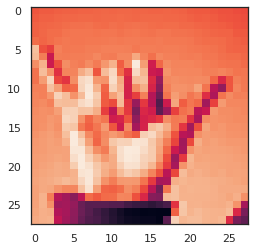

In [0]:
# Examples
g = plt.imshow(X_train[0][:,:,0])


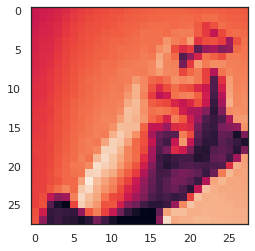

In [0]:
g1 = plt.imshow(X_train[1][:,:,0])


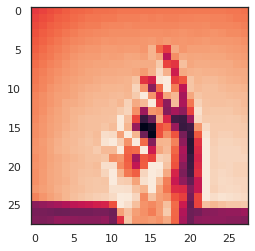

In [0]:
g2 =plt.imshow(X_train[13][:,:,0])

## define CNN model

In [0]:
# Set the CNN model 
# CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(24, activation = "softmax"))

## set optimizer and annealer

In [0]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [0]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [0]:
epochs = 10
batch_size = 128

In [0]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=25,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0, # Randomly zoom image 
        width_shift_range=0,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images


datagen.fit(X_train)

In [0]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/10
 - 4s - loss: 3.0397 - acc: 0.0917 - val_loss: 2.4633 - val_acc: 0.2438
Epoch 2/10
 - 3s - loss: 2.3636 - acc: 0.2540 - val_loss: 1.6436 - val_acc: 0.5101
Epoch 3/10
 - 3s - loss: 1.8499 - acc: 0.3968 - val_loss: 1.2976 - val_acc: 0.6012
Epoch 4/10
 - 3s - loss: 1.4484 - acc: 0.5159 - val_loss: 0.6950 - val_acc: 0.7896
Epoch 5/10
 - 3s - loss: 1.1840 - acc: 0.5941 - val_loss: 0.5124 - val_acc: 0.8456
Epoch 6/10
 - 3s - loss: 0.9971 - acc: 0.6571 - val_loss: 0.4218 - val_acc: 0.8934
Epoch 7/10
 - 3s - loss: 0.8492 - acc: 0.7045 - val_loss: 0.3282 - val_acc: 0.9241
Epoch 8/10
 - 3s - loss: 0.7426 - acc: 0.7415 - val_loss: 0.2364 - val_acc: 0.9383
Epoch 9/10
 - 3s - loss: 0.6679 - acc: 0.7696 - val_loss: 0.1757 - val_acc: 0.9595
Epoch 10/10
 - 3s - loss: 0.5910 - acc: 0.7978 - val_loss: 0.1522 - val_acc: 0.9601


## evaluate the model

### training and validation curves

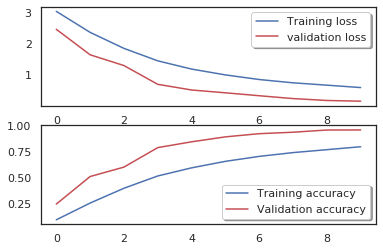

In [0]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

## confusion matrix

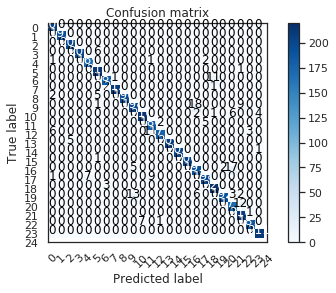

In [0]:
# Plot the confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(25)) 

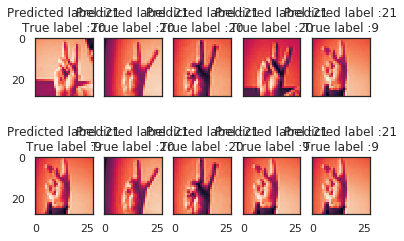

In [0]:
# Display a sample of error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 10 images (2 rows x 5 columns) with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 5
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_delta_errors = np.argsort(delta_pred_true_errors)

# Top 10 errors 
most_important_errors = sorted_delta_errors[-10:]

# Show the top 10 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

In [0]:
#applying the model to the test set
y_pred = model.predict(X_test)

In [0]:
from sklearn.metrics import accuracy_score
accuracy_score(Y_test, y_pred.round())

0.850808700501952